# Distance-based treatment effects

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

Expand on the example in the previous document.

## Notebook admin

In [52]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import copy

from stroke_outcome.continuous_outcome import Continuous_outcome

In [53]:
# Set up MatPlotLib
%matplotlib inline

In [54]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

## Define travel time grids

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

| Centre | x | y |
| --- | --- | --- |
| IVT | 0 | 0 |
| IVT/MT | 0 | $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$ |

In [55]:
travel_ivt_to_mt = 50

In [56]:
ivt_coords = [0, 0]
mt_coords  = [0, -travel_ivt_to_mt]

Change these parameters:

In [57]:
# Only calculate travel times up to this x or y displacement:
time_travel_max = 80

# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [58]:
def make_time_grid(
        xy_max,
        step,
        x_offset=0,
        y_offset=0
    ):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Build the grids:

In [59]:
grid_time_travel_directly_to_ivt = make_time_grid(
    time_travel_max,
    grid_step,
    x_offset=ivt_coords[0], 
    y_offset=ivt_coords[1]
)

In [60]:
grid_time_travel_directly_to_mt = make_time_grid(
    time_travel_max,
    grid_step,
    x_offset=mt_coords[0],
    y_offset=mt_coords[1]
)

In [61]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

In [62]:
extent = [
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5,
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5
]

In [63]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max
)

coords_valid = np.where(grid_mask<1)

## Define total time grids (including fixed times for delays)

Fixed times for additional delays:

In [64]:
# All fixed times have units of minutes
fixed_times = dict(
    onset_to_ambulance_arrival = 60,
    ivt_arrival_to_treatment = 30,
    transfer_additional_delay = 60,
    travel_ivt_to_mt = travel_ivt_to_mt,
    mt_arrival_to_treatment = 90,
    )

In [65]:
pd.DataFrame(fixed_times.values(), index=fixed_times.keys(), 
             columns=['Fixed time (minutes)'])

,Fixed time (minutes)
onset_to_ambulance_arrival,60
ivt_arrival_to_treatment,30
transfer_additional_delay,60
travel_ivt_to_mt,50
mt_arrival_to_treatment,90


In [66]:
grid_time_ivt_at_ivtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment']
    )

In [67]:
grid_time_ivt_at_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment'] + 
    fixed_times['transfer_additional_delay'] + 
    fixed_times['travel_ivt_to_mt'] + 
    fixed_times['mt_arrival_to_treatment']
    )

In [68]:
grid_time_ivt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['ivt_arrival_to_treatment']
    )

In [69]:
grid_time_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['mt_arrival_to_treatment']
    )

__check the assumption of time between IVT and MT at the same centre above__

### Create outcome model inputs

In [70]:
df_ivtcentre = pd.DataFrame()
df_ivtcentre['onset_to_needle_mins'] = grid_time_ivt_at_ivtcentre.flatten()
df_ivtcentre['onset_to_puncture_mins'] = grid_time_ivt_at_ivt_then_mt_at_mtcentre.flatten()

In [71]:
df_ivtmtcentre = pd.DataFrame()
df_ivtmtcentre['onset_to_needle_mins'] = grid_time_ivt_at_mtcentre.flatten()
df_ivtmtcentre['onset_to_puncture_mins'] = grid_time_ivt_then_mt_at_mtcentre.flatten()

Assign three cohorts to these treatment times:

+ nLVO + IVT
+ LVO + IVT
+ LVO + MT

In [72]:
df_ivtcentre_nlvo_ivt = df_ivtcentre.copy()
df_ivtcentre_nlvo_ivt['stroke_type_code'] = 1
df_ivtcentre_nlvo_ivt['ivt_chosen_bool'] = 1
df_ivtcentre_nlvo_ivt['mt_chosen_bool'] = 0

In [73]:
df_ivtmtcentre_nlvo_ivt = df_ivtmtcentre.copy()
df_ivtmtcentre_nlvo_ivt['stroke_type_code'] = 1
df_ivtmtcentre_nlvo_ivt['ivt_chosen_bool'] = 1
df_ivtmtcentre_nlvo_ivt['mt_chosen_bool'] = 0

In [74]:
df_ivtcentre_lvo_ivt = df_ivtcentre.copy()
df_ivtcentre_lvo_ivt['stroke_type_code'] = 2
df_ivtcentre_lvo_ivt['ivt_chosen_bool'] = 1
df_ivtcentre_lvo_ivt['mt_chosen_bool'] = 0

In [75]:
df_ivtmtcentre_lvo_ivt = df_ivtmtcentre.copy()
df_ivtmtcentre_lvo_ivt['stroke_type_code'] = 2
df_ivtmtcentre_lvo_ivt['ivt_chosen_bool'] = 1
df_ivtmtcentre_lvo_ivt['mt_chosen_bool'] = 0

In [76]:
df_ivtcentre_lvo_mt = df_ivtcentre.copy()
df_ivtcentre_lvo_mt['stroke_type_code'] = 2
df_ivtcentre_lvo_mt['ivt_chosen_bool'] = 1
df_ivtcentre_lvo_mt['mt_chosen_bool'] = 1

In [77]:
df_ivtmtcentre_lvo_mt = df_ivtmtcentre.copy()
df_ivtmtcentre_lvo_mt['stroke_type_code'] = 2
df_ivtmtcentre_lvo_mt['ivt_chosen_bool'] = 1
df_ivtmtcentre_lvo_mt['mt_chosen_bool'] = 1

### Calculate outcomes

Imports for the clinical outcome model:

In [78]:
# Set up outcome model
outcome_model = Continuous_outcome()

In [79]:
dfs = [
    df_ivtcentre_nlvo_ivt,
    df_ivtmtcentre_nlvo_ivt,
    df_ivtcentre_lvo_ivt,
    df_ivtmtcentre_lvo_ivt,
    df_ivtcentre_lvo_mt,
    df_ivtmtcentre_lvo_mt,
]

for df in dfs:
    outcome_model.assign_patients_to_trial(df)
    
    # Calculate outcomes:
    patient_data_dict, outcomes_by_stroke_type, full_cohort_outcomes = (
        outcome_model.calculate_outcomes())
    
    # Make a copy of the results:
    outcomes_by_stroke_type = copy.copy(outcomes_by_stroke_type)
    full_cohort_outcomes = copy.copy(full_cohort_outcomes)
    
    # Place the relevant results into the starting dataframe:
    df['added_utility'] = full_cohort_outcomes['each_patient_utility_shift']
    df['mean_mrs'] = full_cohort_outcomes['each_patient_mrs_post_stroke']
    df['mrs_less_equal_2'] = full_cohort_outcomes['each_patient_mrs_dist_post_stroke'][:, 2]
    df['mrs_shift'] = full_cohort_outcomes['each_patient_mrs_shift']

## Combine cohorts into mixed population

Patient population:

In [80]:
patient_props = dict(
    lvo = 0.35,
    nlvo = 1.0-0.35, # 1-LVO
    lvo_mt_also_receiving_ivt = 0.85,
    lvo_treated_ivt_only = 0.0,
    lvo_treated_ivt_mt = 0.286,    # 0.286 gives 10% final MT if 35%LVO
    nlvo_treated_ivt_only = 0.155,    # 0.155 gives final 20% IVT
    )

treated_population = (
    patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_only']
    )

patient_props['treated_population'] = treated_population

Display these values:

In [81]:
df_patients = pd.DataFrame(patient_props.values(), 
    index=patient_props.keys(), columns=['Proportion of patient population'])
df_patients['Comment'] = [
    'Proportion of LVO',
    'Proportion of nLVO', 
    'Proportion LVO MT also receiving IVT',
    'Proportion LVO admissions treated with IVT only',
    'Proportion LVO admissions treated with MT',
    'Proportion nLVO admissions treated with IVT',
    'Proportion all admissions treated'
    ]

df_patients

,Proportion of patient population,Comment
lvo,0.35000,Proportion of LVO
nlvo,0.65000,Proportion of nLVO
lvo_mt_also_receiving_ivt,0.85000,Proportion LVO MT also receiving IVT
lvo_treated_ivt_only,0.00000,Proportion LVO admissions treated with IVT only
lvo_treated_ivt_mt,0.28600,Proportion LVO admissions treated with MT
nlvo_treated_ivt_only,0.15500,Proportion nLVO admissions treated with IVT
treated_population,0.20085,Proportion all admissions treated


Calculate outcomes for the combined cohorts:

In [82]:
outcome_cols = ['added_utility', 'mean_mrs', 'mrs_less_equal_2', 'mrs_shift']

IVT centre grid:

In [83]:
# Combine the outcomes:
df_mixed_ivtcentre = pd.DataFrame(
    np.sum((
        patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] * df_ivtcentre_nlvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_only'] * df_ivtcentre_lvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] * df_ivtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_mixed_ivtcentre = df_mixed_ivtcentre / patient_props['treated_population']

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the nLVO IVT df:
df_mixed_ivtcentre['onset_to_needle_mins'] = df_ivtcentre_nlvo_ivt['onset_to_needle_mins']
df_mixed_ivtcentre['onset_to_puncture_mins'] = df_ivtcentre_nlvo_ivt['onset_to_puncture_mins']

MT centre grid:

In [84]:
# Combine the outcomes:
df_mixed_ivtmtcentre = pd.DataFrame(
    np.sum((
        patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] * df_ivtmtcentre_nlvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_only'] * df_ivtmtcentre_lvo_ivt[outcome_cols],
        patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] * df_ivtmtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_mixed_ivtmtcentre = df_mixed_ivtmtcentre / patient_props['treated_population']

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the nLVO IVT df:
df_mixed_ivtmtcentre['onset_to_needle_mins'] = df_ivtmtcentre_nlvo_ivt['onset_to_needle_mins']
df_mixed_ivtmtcentre['onset_to_puncture_mins'] = df_ivtmtcentre_nlvo_ivt['onset_to_puncture_mins']

Calculate the differences:

In [85]:
df_mixed_diff = df_mixed_ivtcentre - df_mixed_ivtmtcentre

Select colour limits for the circle plot:

In [97]:
def round_to_next(vmin, vmax, r=0.005):
    """Round vmin and vmax to nicer values"""
    vmax_r = np.ceil(np.sign(vmax) * np.abs(vmax) / r) * r
    vmin_r = np.floor(vmin / r) * r
    return vmin_r, vmax_r

In [98]:
# Find the actual minumum and maximum values in the grid:
vmin_total = np.nanmin(df_mixed_diff['added_utility'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])
vmax_total = np.nanmax(df_mixed_diff['added_utility'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])

vmin_util, vmax_util = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_util)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_util)

Max. value in grid: -0.014528277974845169
Chosen vmax:        -0.01
Min. value in grid: -0.04096041955567946
Chosen vmin:        -0.045


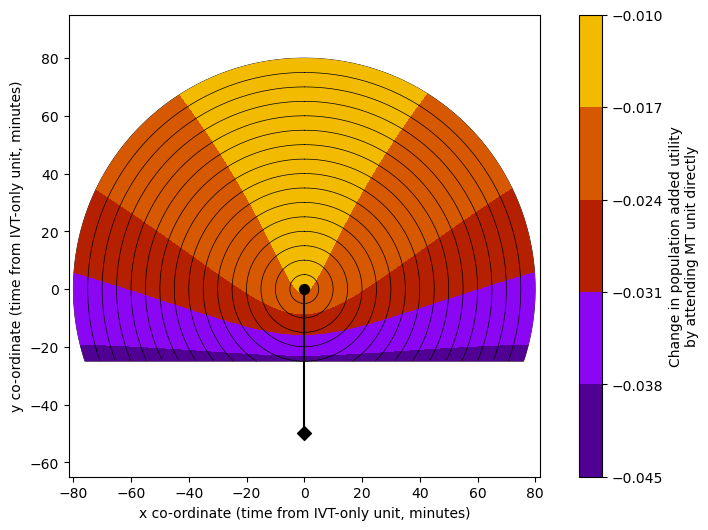

In [99]:
circle_plot(
    df_mixed_diff['added_utility'].values.reshape(grid_time_travel_directly_to_mt.shape),
    fixed_times['travel_ivt_to_mt'], 
    time_travel_max,
    time_step_circle,
    vmin_util,
    vmax_util,
    imshow=0, 
    cmap='gnuplot',
    extent=extent,
    cbar_label=('Change in population added utility\n'+
                'by attending MT unit directly'),
    n_contour_steps = 5, 
    # cbar_format_str='{:3.3f}',
    ivt_coords=ivt_coords,
    mt_coords=mt_coords
    )

Getting another horizontal line halfway between the two centres.

Select colour limits for the circle plot:

In [100]:
# Find the actual maximum value in the grid:
vmin_total = np.nanmin(df_mixed_diff['mrs_shift'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])
vmax_total = np.nanmax(df_mixed_diff['mrs_shift'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])

# Round this up to the nearest nicer thing of our choice:
vmin_mRS, vmax_mRS = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_mRS)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_mRS)

Max. value in grid: 0.21680773530635133
Chosen vmax:        0.22
Min. value in grid: 0.0701622242797923
Chosen vmin:        0.07


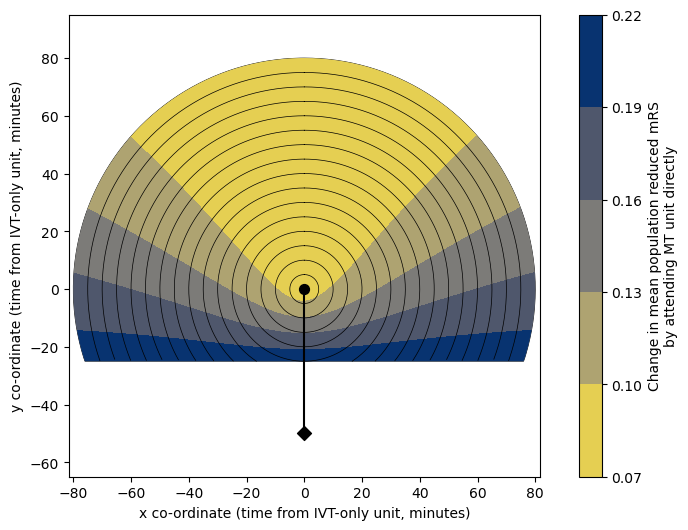

In [101]:
circle_plot(
    df_mixed_diff['mrs_shift'].values.reshape(grid_time_travel_directly_to_mt.shape),
    fixed_times['travel_ivt_to_mt'], 
    time_travel_max,
    time_step_circle,
    vmin_mRS,
    vmax_mRS,
    imshow=0, 
    cmap='cividis_r',
    extent=extent,
    cbar_label=('Change in mean population reduced mRS\n'+
               'by attending MT unit directly'),
    # cbar_format_str='{:3.2f}', 
    n_contour_steps=5,
    ivt_coords=ivt_coords,
    mt_coords=mt_coords
    )